<a href="https://colab.research.google.com/github/Affectiiion/Li_Battery-Model-Comparison/blob/master/model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libaray

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from sklearn.svm import SVR

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

## Helper functions for loading data

In [0]:
#把时间格式转为秒
def convertTimeToSecond(timeString):
    timeList = timeString[5::].split(':')
    seconds = float(timeList[0]) * 60 * 60 + float(timeList[1]) * 60 + float(timeList[2])
    return seconds


#去除数据中的异常值 （最大的十个和最小的十个）
def polishData(c_times, C, d_times):
    n = 10
    for i in range(n):
        s_c_times = np.array(c_times)
        index1 = np.argmax(s_c_times)
        index2 = np.argmin(s_c_times)
        if index1 < index2:
            temp = index1
            index1 = index2
            index2 = temp
        del c_times[index1]
        del C[index1]
        del d_times[index1]       
        del c_times[index2]
        del C[index2]
        del d_times[index2]
        
        s_C = np.array(C)
        index1 = np.argmax(s_C)
        index2 = np.argmin(s_C)
        if index1 < index2:
            temp = index1
            index1 = index2
            index2 = temp
        del c_times[index1]
        del C[index1]
        del d_times[index1]       
        del c_times[index2]
        del C[index2]
        del d_times[index2]
        
        s_d_times = np.array(d_times)
        index1 = np.argmax(s_d_times)
        index2 = np.argmin(s_d_times)
        if index1 < index2:
            temp = index1
            index1 = index2
            index2 = temp
        del c_times[index1]
        del C[index1]
        del d_times[index1]       
        del c_times[index2]
        del C[index2]
        del d_times[index2]
        

In [0]:
#载入一个电池的一个片段
def read_one_episode(episode_path):
    data = pd.read_excel(episode_path)
    data = data[data.State != 'P']
    data = data[data.State != 'S']
    
    cycles = []
    gb = data.groupby('Cyc#')
    for name, cycle in gb:
        cycles.append(cycle)
        
    charge_times = []
    coulombs = []
    discharge_times = []
    
    for cycle in cycles:
        c_d = cycle.groupby('State')
        states = []
        for name, state in c_d:
            states.append(state)
        charge = states[0]
        discharge = states[1]
    
        charge_time = convertTimeToSecond(max(charge.StepTime))
        coulomb = max(discharge['Amp-hr'])
        discharge_time = convertTimeToSecond(discharge['StepTime'].tail(1).item())
    
        charge_times.append(charge_time)
        coulombs.append(coulomb)
        discharge_times.append(discharge_time)
    return charge_times, coulombs, discharge_times

#载入一个电池
def read_one_cell(*episodes_path):
    c_times = []
    C = []
    d_times = []
    for path in episodes_path:
        charge_times, coulombs, discharge_times = read_one_episode(path)
        c_times += charge_times
        C += coulombs
        d_times += discharge_times
        
    #delete outliers in data
    polishData(c_times, C, d_times)
    
    #truncating cycles with charge less than 80% of initial charge
    np_c_times = np.array(c_times)
    np_C = np.array(C)
    np_d_times = np.array(d_times)

    mask = np_C >= (np_C[0] * 0.8)

    np_c_times = np_c_times[mask]
    np_C = np_C[mask]
    np_d_times = np_d_times[mask]

    c_times = list(np_c_times)
    C = list(np_C)
    d_times = list(np_d_times)
    
    return c_times, C, d_times

In [0]:
#path = 'drive/My Drive/'
path = ''

In [0]:
#载入电池530
c_times_530, C_530, d_times_530 = read_one_cell(path + 'cells/530-1r.xlsx', 
                                                path + 'cells/530-2r.xlsx', 
                                                path + 'cells/530-3r.xlsx')

In [0]:
#载入电池537
c_times_537, C_537, d_times_537 = read_one_cell(path + 'cells/537-1r.xlsx', 
                                                path + 'cells/537-2r.xlsx', 
                                                path + 'cells/537-3r.xlsx',
                                                path + 'cells/537-4r.xlsx', 
                                                path + 'cells/537-5r.xlsx')

In [0]:
#载入电池558
c_times_558, C_558, d_times_558 = read_one_cell(path + 'cells/558-1r.xlsx', 
                                                path + 'cells/558-2r.xlsx', 
                                                path + 'cells/558-3r.xlsx',
                                                path + 'cells/558-4r.xlsx')

# SVR Model

In [0]:
#使用537和558作为训练集
c_times = c_times_537 + c_times_558
C = C_537 + C_558
d_times = d_times_537 + d_times_558

In [0]:
X_train = np.zeros((len(C), 3))
X_train[:, 0] = c_times
X_train[:, 1] = C
X_train[:, 2] = d_times

c_times_normalizer = np.mean(X_train[:,0])
C_normalizer = np.mean(X_train[:,1])
d_times_normalizer = np.mean(X_train[:,2])

X_train[:, 0] /= c_times_normalizer
X_train[:, 1] /= C_normalizer
X_train[:, 2] /= d_times_normalizer

In [0]:
y_train = list(range(len(C_537), 0, -1)) + list(range(len(C_558), 0, -1))
y_train = np.array(y_train)

In [0]:
def constructTestSet(c_times, C, d_times, normalizers):
    X_test = np.zeros((len(C), 3))
    X_test[:, 0] = np.array(c_times) / normalizers[0]
    X_test[:, 1] = np.array(C) / normalizers[1]
    X_test[:, 2] = np.array(d_times) / normalizers[2]
    y_test = list(range(len(C), 0, -1))
    y_test = np.array(y_test)
    return X_test, y_test

In [0]:
#使用530作为测试
X_test, y_test = constructTestSet(c_times_530, C_530, d_times_530, [c_times_normalizer, C_normalizer, d_times_normalizer])

In [0]:
#载入模型，kernel使用poly，degree为3
clf = SVR(kernel = 'poly', degree = 3, C=1.0, epsilon=0.2, gamma='scale')

In [0]:
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

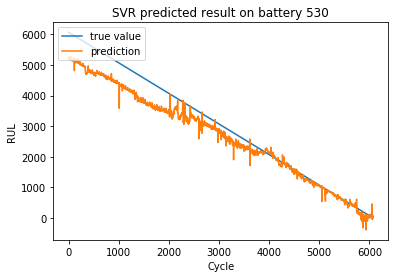

In [0]:
#使用svr做预测
pred = clf.predict(X_test)
plt.plot(y_test)
plt.plot(pred)
plt.title('SVR predicted result on battery 530')
plt.ylabel('RUL')
plt.xlabel('Cycle')
plt.legend(['true value', 'prediction'], loc='upper left')
plt.show()

# LSTM Model

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization

TensorFlow 2.x selected.


In [0]:
#从数据中提取sequence
n_squences = 20
def extractSequence(c_times, C, d_times):
    X = np.zeros((len(C), 3))
    X[:,0] = c_times / c_times_normalizer
    X[:,1] = C / C_normalizer
    X[:,2] = d_times / d_times_normalizer
    X_train = []
    for i in range(n_squences, len(C)):
        X_train.append(X[i - n_squences:i, :])
    return np.array(X_train)

In [0]:
#使用537和558作为训练，530做测试
X_train_lstm_537 = extractSequence(c_times_537, C_537, d_times_537)
y_train_lstm_537 = np.array(list(range(X_train_lstm_537.shape[0], 0, -1)))

X_train_lstm_558 = extractSequence(c_times_558, C_558, d_times_558)
y_train_lstm_558 = np.array(list(range(X_train_lstm_558.shape[0], 0, -1)))

X_test_lstm_530 = extractSequence(c_times_530, C_530, d_times_530)
y_test_lstm_530 = np.array(list(range(X_test_lstm_530.shape[0], 0, -1)))

In [0]:
#搭建LSTM模型
lstm_regressor = Sequential()
lstm_regressor.add(LSTM(units=64, 
                   return_sequences=False, 
                   input_shape=(n_squences, 3)))
lstm_regressor.add(Dense(64, activation='relu'))
lstm_regressor.add(BatchNormalization())
lstm_regressor.add(Dense(64, activation='relu'))
lstm_regressor.add(BatchNormalization())
lstm_regressor.add(Dense(1))

lstm_regressor.compile(optimizer='adam',loss='mean_squared_error')

In [0]:
#训练
for _ in range(20):
    lstm_regressor.fit(X_train_lstm_537, y_train_lstm_537, batch_size = 32, epochs = 3, shuffle=True)
    lstm_regressor.fit(X_train_lstm_558, y_train_lstm_558, batch_size = 32, epochs = 3, shuffle=True)

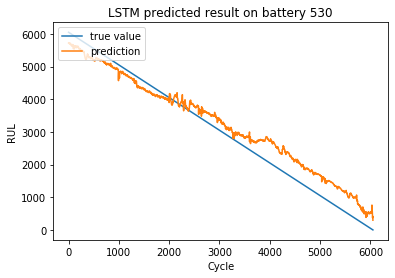

In [0]:
#使用LSTM预测电池530
lstm_pred = lstm_regressor.predict(X_test_lstm_530)
plt.plot(y_test_lstm_530)
plt.plot(lstm_pred)
plt.title('LSTM predicted result on battery 530')
plt.ylabel('RUL')
plt.xlabel('Cycle')
plt.legend(['true value', 'prediction'], loc='upper left')
plt.show()


## GRU Model

In [0]:
from tensorflow.keras.layers import GRU

In [0]:
#训练集与测试集与LSTM相同
#模型的hyperparameters 与 LSTM相同
#LSTM layer 替换为 GRU

In [0]:
gru_regressor = Sequential()
gru_regressor.add(GRU(units=64, 
                   return_sequences=False, 
                   input_shape=(n_squences, 3)))
gru_regressor.add(Dense(64, activation='relu'))
gru_regressor.add(BatchNormalization())
gru_regressor.add(Dense(64, activation='relu'))
gru_regressor.add(BatchNormalization())
gru_regressor.add(Dense(1))

gru_regressor.compile(optimizer='adam',loss='mean_squared_error')

In [0]:
#训练
for _ in range(20):
    gru_regressor.fit(X_train_lstm_537, y_train_lstm_537, batch_size = 32, epochs = 3, shuffle=True)
    gru_regressor.fit(X_train_lstm_558, y_train_lstm_558, batch_size = 32, epochs = 3, shuffle=True)

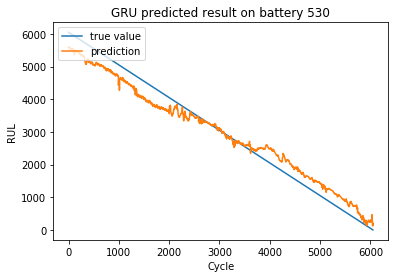

In [0]:
#使用GRU预测电池530
gru_pred = gru_regressor.predict(X_test_lstm_530)
plt.plot(y_test_lstm_530)
plt.plot(gru_pred)
plt.title('GRU predicted result on battery 530')
plt.ylabel('RUL')
plt.xlabel('Cycle')
plt.legend(['true value', 'prediction'], loc='upper left')
plt.show()

# 对比图

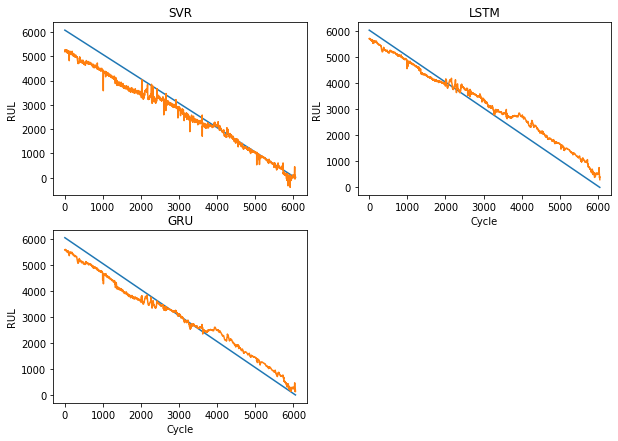

In [0]:
svr_pred = clf.predict(X_test)
lstm_pred = lstm_regressor.predict(X_test_lstm_530)
gru_pred = gru_regressor.predict(X_test_lstm_530)

f = plt.figure(figsize=(10, 7))

svr = f.add_subplot(221)
lstm = f.add_subplot(222)
gru = f.add_subplot(223)

svr.set_title('SVR')
svr.set_ylabel('RUL')
#svr.set_xlabel('Cycle')
svr.plot(y_test)
svr.plot(svr_pred)

lstm.set_title('LSTM')
lstm.set_ylabel('RUL')
lstm.set_xlabel('Cycle')
lstm.plot(y_test_lstm_530)
lstm.plot(lstm_pred)

gru.set_title('GRU')
gru.set_ylabel('RUL')
gru.set_xlabel('Cycle')
gru.plot(y_test_lstm_530)
gru.plot(gru_pred)

plt.show()

In [0]:
gc.collect()

0

In [0]:
#结论
'''
SVR稳定性较好，通过convex optimization找全局最优解。但训练时间大于O(n²)，难以训练大量数据（一万数据以上）

GRU与LSTM性能近似，训练时间基本为线性，可在大量数据上训练。但由于神经网络的损失函数nonconvex，
在regression问题上不如SVR稳定，训练时会停在局部最优解。进一步调整模型参数以及增加数据
可能缓和这个问题
'''